## Load graph
Parsing GFA file manually, since GfaPy takes a strangely long amount of time reading through it.

In [1]:
import networkx as nx
import matplotlib
from matplotlib import pyplot
from statistics import median

# Loads the new graph
FILENAME = "/home/marcus/PevznerLabBigData/20201014_graph/noseq.gfa"

# We ignore directionality for right now
graph = nx.Graph()

with open(FILENAME, "r") as gfafile:
    for line in gfafile:
        if line[0] == "S":
            parts = line.strip().split("\t")
            node_name = parts[1]
            node_len = None
            node_cov = None
            extra_data = parts[3:]
            for tag in extra_data:
                if tag.startswith("LN:i:"):
                    if node_len is None:
                        node_len = int(tag[5:])
                    else:
                        raise ValueError("Duplicate length for node {}".format(node_name))
                elif tag.startswith("dp:i:"):
                    if node_cov is None:
                        node_cov = int(tag[5:])
                    else:
                        raise ValueError("Duplicate coverage for node {}".format(node_name))
            graph.add_node(node_name, length=node_len, cov=node_cov)
        elif line[0] == "L":
            parts = line.strip().split("\t")
            src = parts[1]
            snk = parts[3]
            # Ignore directionality for just right now; this means that some links will be "repeated" (for
            # the new graph this means that the NX representation has 484 less links)
            graph.add_edge(src, snk)

node2len = nx.get_node_attributes(graph, "length")
node2cov = nx.get_node_attributes(graph, "cov")
            
print("Graph contains {} edges (represented as GFA segments).".format(graph.number_of_nodes()))
print("Graph contains {} links between edges (ignoring directionality for now).".format(graph.number_of_edges()))
print("Graph contains {} connected components.".format(nx.number_connected_components(graph)))

Graph contains 36260 edges (represented as GFA segments).
Graph contains 40545 links between edges (ignoring directionality for now).
Graph contains 8655 connected components.


## Visualize pileups

### 0. Compute "real" coverage based on alignments

Go through pileup for each of the edges, compute number of mapped reads at each position, and average over all positions in the sequence. Will be more accurate than the value reported in the graph, at least from the perspective of the data we're looking at.

In [2]:
from statistics import mean
from collections import defaultdict

edgenum2coverages = defaultdict(list)
with open("/home/marcus/PevznerLabBigData/20201014_graph/5xdata-pileup.txt", "r") as pf:
    for line in pf:
        split = line.split("\t")
        lineheader = split[0]
        edgenum = lineheader.split("_")[1]
        position_coverage = int(split[3])
        edgenum2coverages[edgenum].append(position_coverage)
        
for edge in edgenum2coverages:
    print("Edge {} (length {}): {} positions in pileup. Average coverage = {:.2f}. Median coverage = {}.".format(
        edge, node2len[edge], len(edgenum2coverages[edge]), mean(edgenum2coverages[edge]),
        median(edgenum2coverages[edge])
    ))

Edge 166 (length 1302342): 1302342 positions in pileup. Average coverage = 527.11. Median coverage = 527.0.
Edge 6018 (length 2232606): 2232606 positions in pileup. Average coverage = 515.58. Median coverage = 507.0.
Edge 7998 (length 1634900): 1634900 positions in pileup. Average coverage = 796.41. Median coverage = 786.0.


### 1. Visualizing "disagreement frequency"

For each edge sequence, find the number of matches (`.` or `,` characters) and return

\begin{equation}
\frac{1 - \text{Number of matching reads}}{\text{Number of aligned reads}}
\end{equation}

In [ ]:
# for e in ("1010", "3172", "12782", "836", "842", "31439", "3175", "831", "833", "12783"):
#     with open("/home/marcus/PevznerLabBigData/20201014_graph/selected_pileup.txt", "r") as pf:
#         mutations_for_edge = []
#         pos = []
#         edge_header = "edge_{}_".format(e)
#         for line in pf:
#             if line.startswith(edge_header):
#                 split = line.split("\t")
#                 num_matches = split[4].count(".") + split[4].count(",")
#                 mutations_for_edge.append(1 - (num_matches / int(split[3])))
#                 pos.append(int(split[1]))

#     pyplot.scatter(x=pos, y=mutations_for_edge)
#     pyplot.title("Edge {}: Disagreement 'frequency'".format(e))
#     pyplot.xlabel("Sequence position")
#     pyplot.ylabel("Mutation frequency")
#     pyplot.ylim(bottom=0)
#     pyplot.show()

### 2. Visualizing raw number of discordant aligned reads

For each edge sequence, find the number of matches (`.` or `,` characters) and return

\begin{equation}
\text{Number of aligned reads} - \text{Number of matching reads}
\end{equation}

Same noise thing with ASCII characters applies.

In [10]:
from collections import defaultdict
edge2mutations = defaultdict(list)
edge2pos = defaultdict(list)
with open("/home/marcus/PevznerLabBigData/20201014_graph/5xdata-pileup.txt", "r") as pf:
    for line in pf:
        split = line.split("\t")
        lineheader = split[0]
        edgenum = lineheader.split("_")[1]
        num_matches = split[4].count(".") + split[4].count(",")
        edge2mutations[edgenum].append(int(split[3]) - num_matches)
        edge2pos[edgenum].append(int(split[1]))
        
# Following this, on the cluster I converted edge2mutations and edge2pos to json files using
# the https://stackoverflow.com/a/7100202/10730311 approach.

In [11]:
# import json
# with open("/home/marcus/PevznerLabBigData/20201014_graph/e2m.json", "r") as mf:
#     edge2mutations = json.load(mf)
# with open("/home/marcus/PevznerLabBigData/20201014_graph/e2p.json", "r") as pf:
#     edge2pos = json.load(pf)

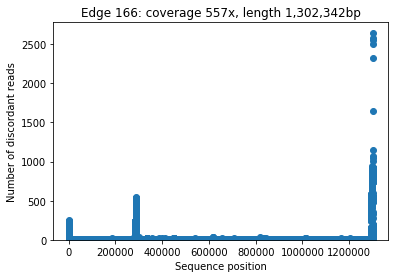

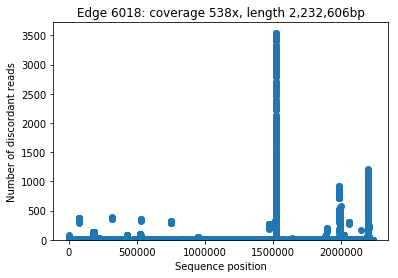

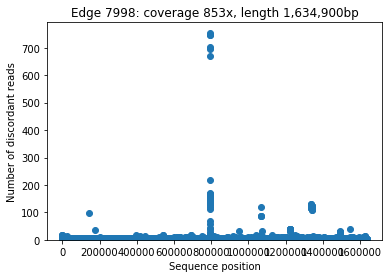

In [12]:
for e in edge2mutations.keys():
    pyplot.scatter(x=edge2pos[e], y=edge2mutations[e])
    pyplot.title("Edge {}: coverage {:,}x, length {:,}bp".format(e, node2cov[e], node2len[e]))
    pyplot.xlabel("Sequence position")
    pyplot.ylabel("Number of discordant reads")
    pyplot.ylim(bottom=0)
    pyplot.show()

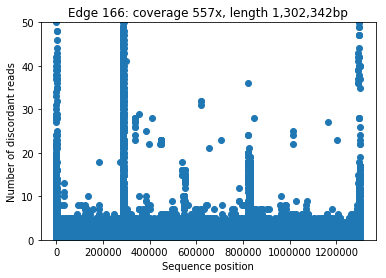

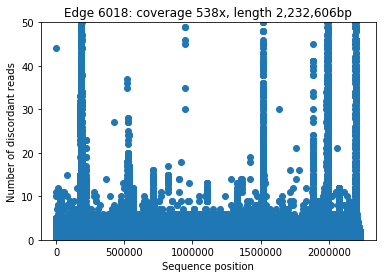

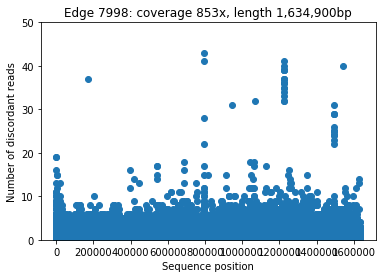

In [13]:
# Spectra but zoomed in to [0, 50]
for e in edge2mutations.keys():
    pyplot.scatter(x=edge2pos[e], y=edge2mutations[e])
    pyplot.title("Edge {}: coverage {:,}x, length {:,}bp".format(e, node2cov[e], node2len[e]))
    pyplot.xlabel("Sequence position")
    pyplot.ylabel("Number of discordant reads")
    pyplot.ylim(bottom=0, top=50)
    pyplot.show()

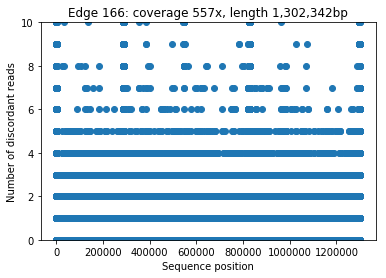

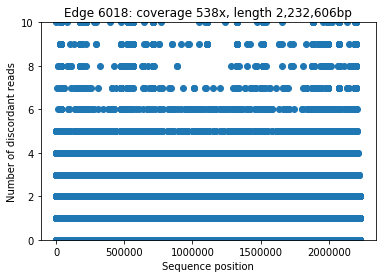

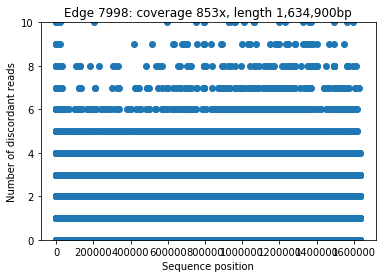

In [9]:
# Spectra but zoomed in to [0, 10]
for e in edge2mutations.keys():
    pyplot.scatter(x=edge2pos[e], y=edge2mutations[e])
    pyplot.title("Edge {}: coverage {:,}x, length {:,}bp".format(e, node2cov[e], node2len[e]))
    pyplot.xlabel("Sequence position")
    pyplot.ylabel("Number of discordant reads")
    pyplot.ylim(bottom=0, top=10)
    pyplot.show()

## Go through predicted genes and compute mutation frequencies at 1st, 2nd, 3rd positions

In [14]:
from collections import defaultdict

In [20]:
# Looks like {7998: {1: 1, 2: 0.75, 3: 0.5, 4: 1, ...}}

# This uses "mutation rate" at each position, so min is 0 and max is 1.
edge2pos2mutfreq = defaultdict(dict)
with open("/home/marcus/PevznerLabBigData/20201014_graph/5xdata-pileup.txt", "r") as pf:
    for line in pf:
        split = line.split("\t")
        lineheader = split[0]
        edgenum = lineheader.split("_")[1]
        num_matches = split[4].count(".") + split[4].count(",")
        
        # use 1-indexed coordinates, since MetaGeneMark does in its output (as far as I can tell).
        # Fortunately pileup also uses 1-indexed coordinates.
        pos = int(split[1])
        mutation_freq = 1 - (num_matches / int(split[3]))
        if mutation_freq >= 0.01:
            edge2pos2mutfreq[edgenum][pos] = 1
        else:
            edge2pos2mutfreq[edgenum][pos] = 0

In [21]:
# # Similar to above, but uses just number of discordant reads.
# edge2pos2mutfreq = defaultdict(dict)
# with open("/home/marcus/PevznerLabBigData/20201014_graph/scf-pileup.txt", "r") as pf:
#     for line in pf:
#         split = line.split("\t")
#         lineheader = split[0]
#         edgenum = lineheader.split("_")[1]
#         num_matches = split[4].count(".") + split[4].count(",")
        
#         # use 1-indexed coordinates, since MetaGeneMark does in its output (as far as I can tell).
#         # Fortunately pileup also uses 1-indexed coordinates.
#         pos = int(split[1])
#         mutation_freq = int(split[3]) - num_matches
#         edge2pos2mutfreq[edgenum][pos] = mutation_freq

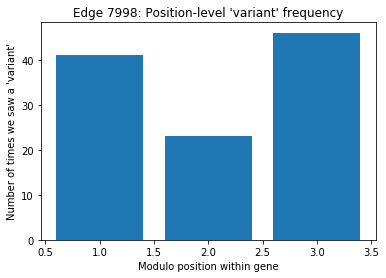

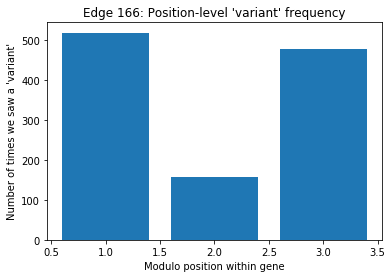

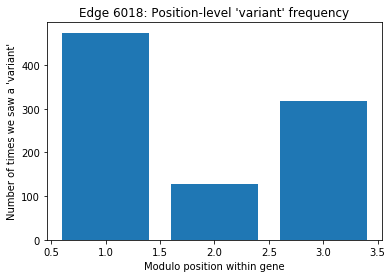

In [27]:
import pandas as pd
from statistics import mean, median

# TODO debug -- or try filtering mutations

for edge in ["7998", "166", "6018"]:
    mgm = pd.read_csv(
        "/home/marcus/PevznerLabBigData/20201014_graph/{}_mgm_genes.txt".format(edge),
        sep="\s+", skiprows=[1], index_col=0, header=0, names=["Strand", "LeftEnd", "RightEnd", "Length", "Class"]
    )

    # Total mutation rates for each of the 0th, 1st, 2nd positions in the gene regions
    # (repeating, so it goes 0, 1, 2, 0, 1, 2, ...)
    zero_mut_rates = []
    one_mut_rates = []
    two_mut_rates = []
    for gene in mgm.itertuples():
        # only consider genes with >= 500 putative amino acids
        if gene.Length < 1500:
            # print("Gene {} has len {}, less than 300.".format(gene.Index, gene.Length))
            continue
        
        try:
            start = int(gene.LeftEnd)
        except ValueError:
            # Account for the "<2" left end coordinate in one of the genes predicted
            start = int(gene.LeftEnd[1:])
        end = int(gene.RightEnd)
        
        i = 0
        for pos in range(start, end + 1):
            if i == 0:
                zero_mut_rates.append(edge2pos2mutfreq[edge][pos])
                i = 1
            elif i == 1:
                one_mut_rates.append(edge2pos2mutfreq[edge][pos])
                i = 2
            elif i == 2:
                two_mut_rates.append(edge2pos2mutfreq[edge][pos])
                i = 0
            else:
                raise ValueError("Marcus forgot how modulos work, go yell at him pls")
                
        if i != 0:
            raise ValueError("Gene length not divisible by 3.")
        
        #print("0s:", sorted(zero_mut_rates))
        # print("Edge {}, gene {}: {} | {} | {}".format(edge, gene.Index, *mut_rates))
        
    num_genes = len(zero_mut_rates)
    assert len(zero_mut_rates) == len(one_mut_rates) == len(two_mut_rates)
    pyplot.bar(x=[1, 2, 3], height=[sum(zero_mut_rates), sum(one_mut_rates), sum(two_mut_rates)])
    pyplot.title("Edge {}: Position-level 'variant' frequency".format(edge))
    pyplot.xlabel("Modulo position within gene")
    pyplot.ylabel("Number of times we saw a 'variant'")
    pyplot.show()

## Prove that for every edge E in the graph, E and -E are not in the same weakly connected component

In [23]:
FILENAME = "/home/marcus/PevznerLabBigData/20201014_graph/noseq.gfa"

# We ignore directionality for right now
graph = nx.DiGraph()

def invert_orient(orient):
    if orient == "+":
        return "-"
    elif orient == "-":
        return "+"
    else:
        raise ValueError("Invalid orienatation {}".format(orient))

# !!! Load graph in "double" mode, i.e. treating each edge's + and - as two objects. !!!
        
with open(FILENAME, "r") as gfafile:
    for line in gfafile:
        if line[0] == "S":
            parts = line.strip().split("\t")
            node_name = parts[1]
            node_len = None
            node_cov = None
            extra_data = parts[3:]
            for tag in extra_data:
                if tag.startswith("LN:i:"):
                    if node_len is None:
                        node_len = int(tag[5:])
                    else:
                        raise ValueError("Duplicate length for node {}".format(node_name))
                elif tag.startswith("dp:i:"):
                    if node_cov is None:
                        node_cov = int(tag[5:])
                    else:
                        raise ValueError("Duplicate coverage for node {}".format(node_name))
            graph.add_node(node_name + "+", length=node_len, cov=node_cov)
            graph.add_node(node_name + "-", length=node_len, cov=node_cov)
        elif line[0] == "L":
            parts = line.strip().split("\t")
            src = parts[1]
            src_orient = parts[2]
            snk = parts[3]
            snk_orient = parts[2]
            
            graph.add_edge(src + src_orient, snk + snk_orient)
            graph.add_edge(snk + invert_orient(snk_orient), src + invert_orient(src_orient))

In [24]:
sorted_components = sorted(
    nx.weakly_connected_components(graph),
    key=len,
    reverse=True
)
for cmp in sorted_components:
    for node in cmp:
        rc = node[:-1] + invert_orient(node[-1])
        if rc in cmp:
            print(node, rc, "in same weakly connected component!")